In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/creditcardfraud/creditcard.csv


## Parse CSV and clean-up

In [2]:
import csv
import matplotlib.pyplot as plt

fname = "/kaggle/input/creditcardfraud/creditcard.csv"

all_features = []
all_targets = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


## Split to training and validation sets

In [3]:
num_val_samples = int(len(features) * 0.2) # 20% for validation
X_train = features[:-num_val_samples]
y_train = targets[:-num_val_samples]
X_test = features[-num_val_samples:]
y_test = targets[-num_val_samples:]

print("# of training samples:", len(X_train))
print("# of validation samples:", len(X_test))

# of training samples: 227846
# of validation samples: 56961


## Check class-imbalance 
To be use as class weights in training

In [4]:
counts = np.bincount(y_train[:, 0])
print(
    "# of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

# of positive samples in training data: 417 (0.18% of total)


## Standard Scaler preprocessing

In [5]:
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean
std = np.std(X_train, axis=0)
X_train /= std
X_test /= std

# Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [7]:
from matplotlib import pyplot

importance = logreg.coef_.ravel()

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.11805
Feature: 1, Score: 0.12693
Feature: 2, Score: 0.07433
Feature: 3, Score: 0.05294
Feature: 4, Score: 0.93693
Feature: 5, Score: 0.13894
Feature: 6, Score: -0.13283
Feature: 7, Score: -0.12672
Feature: 8, Score: -0.18478
Feature: 9, Score: -0.31283
Feature: 10, Score: -0.87192
Feature: 11, Score: -0.06050
Feature: 12, Score: 0.05762
Feature: 13, Score: -0.27796
Feature: 14, Score: -0.50946
Feature: 15, Score: -0.04487
Feature: 16, Score: -0.17416
Feature: 17, Score: 0.01395
Feature: 18, Score: 0.04946
Feature: 19, Score: 0.04040
Feature: 20, Score: -0.37768
Feature: 21, Score: 0.28417
Feature: 22, Score: 0.46586
Feature: 23, Score: -0.08879
Feature: 24, Score: 0.02068
Feature: 25, Score: -0.00756
Feature: 26, Score: 0.06802
Feature: 27, Score: -0.32704
Feature: 28, Score: -0.10202
Feature: 29, Score: 0.26073


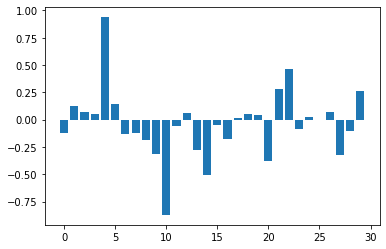

In [8]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [9]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

#y_test_prob_lr = logreg.predict_proba(X_test)
y_score_lr = logreg.predict(X_test).ravel()

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
print("ROC AUC:", roc_auc_lr)

ROC AUC: 0.779964841964631


In [10]:
precision_lr, recall_lr, thresholds_lr_2 = precision_recall_curve(y_test, y_score_lr)
pr_auc_lr = auc(precision_lr, recall_lr)
print("PR AUC:", pr_auc_lr)

PR AUC: 0.735494720644102


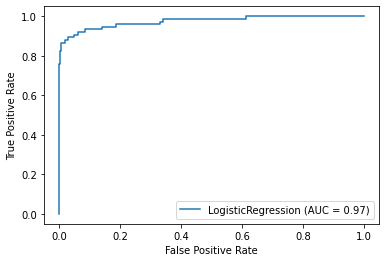

In [11]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
fig = plot_roc_curve(logreg, X_test, y_test)  
plt.show() 

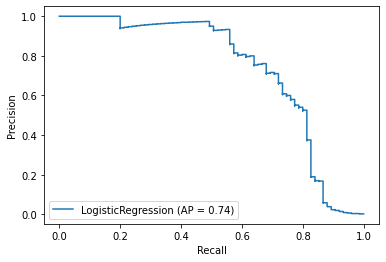

In [12]:
plot_precision_recall_curve(logreg, X_test, y_test)  
plt.show() 

# Feed Forward NN

In [13]:
from tensorflow import keras

nn_clf = keras.Sequential(
    [
        keras.layers.Dense(256, activation="relu", input_shape=(X_train.shape[-1],)),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
nn_clf.summary()

2021-09-11 14:17:00.336996: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-11 14:17:00.337131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 139,777
Trainable params: 139,777
Non-trainable params: 0
__________________________________________________

2021-09-11 14:17:05.537990: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-11 14:17:05.541143: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-11 14:17:05.541211: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-11 14:17:05.541242: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e51761442676): /proc/driver/nvidia/version does not exist
2021-09-11 14:17:05.541593: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

## Train with class-weight as inverse of example-count in training set

In [14]:
metrics = [
    keras.metrics.FalseNegatives(name="fn_nn"),
    keras.metrics.FalsePositives(name="fp_nn"),
    keras.metrics.TrueNegatives(name="tn_nn"),
    keras.metrics.TruePositives(name="tp_nn"),
    keras.metrics.Precision(name="precision_nn"),
    keras.metrics.Recall(name="recall_nn"),
]

nn_clf.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

nn_clf.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=2,#change to 200
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
)

2021-09-11 14:17:05.972848: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-11 14:17:05.988370: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/2
112/112 - 7s - loss: 2.3451e-06 - fn_nn: 44.0000 - fp_nn: 24690.0000 - tn_nn: 202739.0000 - tp_nn: 373.0000 - precision_nn: 0.0149 - recall_nn: 0.8945 - val_loss: 0.0833 - val_fn_nn: 11.0000 - val_fp_nn: 969.0000 - val_tn_nn: 55917.0000 - val_tp_nn: 64.0000 - val_precision_nn: 0.0620 - val_recall_nn: 0.8533
Epoch 2/2
112/112 - 4s - loss: 1.3639e-06 - fn_nn: 37.0000 - fp_nn: 8296.0000 - tn_nn: 219133.0000 - tp_nn: 380.0000 - precision_nn: 0.0438 - recall_nn: 0.9113 - val_loss: 0.0924 - val_fn_nn: 8.0000 - val_fp_nn: 1117.0000 - val_tn_nn: 55769.0000 - val_tp_nn: 67.0000 - val_precision_nn: 0.0566 - val_recall_nn: 0.8933


In [15]:
# explain predictions of the model on four images
explainer = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = explainer.shap_values(X_test[1:5])

NameError: name 'shap' is not defined

In [ ]:
import shap

# load JS visualization
shap.initjs()

# explain the model's predictions using SHAP
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(nn_clf, background)
shap_values = explainer.shap_values(X_test[1:5])

In [ ]:
shap_values

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test[0,:], link="logit")
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

#perm = PermutationImportance(nn_clf, random_state=1).fit(X_test, y_test)
#eli5.show_weights(perm, feature_names = X.columns.tolist())

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

#y_test_prob_nn = nn_clf.predict_proba(X_test)
y_score_nn = nn_clf.predict(X_test).ravel()

fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_score_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)
print("ROC AUC:", roc_auc_nn)

In [ ]:
#precision_nn, recall_nn, thresholds_nn_2 = precision_recall_curve(y_test, y_score_nn)
#pr_auc_nn = auc(precision_nn, recall_nn)
#print("PR AUC:", pr_auc_nn)

## Plot ROC & Precision-Recall Curves

In [ ]:
# Custom plot functions for Keras 
def plot_my_roc_curve(fpr, tpr): 
  plt.plot(fpr, tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()

def plot_my_pr_curve(precision, recall): 
  plt.plot(precision, recall) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('Precision') 
  plt.ylabel('Recall') 
  plt.show()

In [ ]:
plot_my_roc_curve (fpr_nn, tpr_nn) 

In [ ]:
plot_my_pr_curve (precision_nn, recall_nn) 

In [ ]:
#fig = plot_roc_curve(nn_clf, X_test, y_test)  
#plt.show() 

In [ ]:
#plot_precision_recall_curve(nn_clf, X_test, y_test)  
#plt.show()

# Explainable Boosting Machine

In [ ]:
!pip install interpret -q

In [ ]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

## Train Explainable Boosting Classifier

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

ebm = ExplainableBoostingClassifier(random_state=1)
ebm.fit(X_train, y_train)

## EBM AUC

In [ ]:
#y_test_prob_ebm = ebm.predict_proba(X_test)
y_score_ebm = ebm.predict(X_test).ravel()

fpr_ebm, tpr_ebm, thresholds_ebm = roc_curve(y_test, y_score_ebm)
roc_auc_ebm = auc(fpr_ebm, tpr_ebm)
print("ROC AUC:", roc_auc_ebm)

In [ ]:
precision_ebm, recall_ebm, thresholds1_ebm = precision_recall_curve(y_test, y_score_ebm)
pr_auc_ebm = auc(precision_ebm, recall_ebm)
print("PR AUC:", pr_auc_ebm)

## Plot ROC Curve

In [ ]:
plot_my_roc_curve (fpr_ebm, tpr_ebm) 

In [ ]:
fig = plot_roc_curve(ebm, X_test, y_test)  
plt.show() 

## Plot PR Curve

In [ ]:
plot_precision_recall_curve(ebm, X_test, y_test)  
plt.show()

## Plot Feature Global & Local Feature Attributions

In [ ]:
ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)